In [2]:
import torch
import gc
from dataloader import CustomImageDataset, DataLoader
from torchvision.transforms import Compose
import torchvision.transforms as transforms
from utils import transform


dataset = CustomImageDataset(annotations_dir = '../MNIST-ObjectDetection/data/mnist_detection/test/labels',
                             img_dir = '../MNIST-ObjectDetection/data/mnist_detection/test/images',
                             data_transform = transform,
                             size=(448,448))

train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

device = torch.device('cuda:0')

In [3]:
from model import YOLOv1, YOLOv1_resnet
import torchvision.transforms as T
from torch import nn
from torch import optim
import numpy as np
from utils import plot_images, clean_gpu, initialize_weights

# to plot the loss
loss_history = []

# clean gpu before wathever
clean_gpu()

# model
model = YOLOv1_resnet(S=7, depth=12).to(device)
#model.apply(initialize_weights)
model.train()

# optimizatino algorithm
mse = nn.MSELoss(reduction='sum')
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.5)

In [4]:
def yolov1_loss_function(loss_metric, target, prediction):

    target_confidence_obj = target['one_obj'].to(device).squeeze()
    target_classification = target['class'].to(device).squeeze()

    predict_confidence_obj = prediction[...,0].squeeze()
    predict_classification = (prediction[...,1:12].squeeze())


    loss = loss_metric(
        torch.flatten(target_confidence_obj, start_dim=1), 
        torch.flatten(predict_confidence_obj*target_confidence_obj, start_dim=1)
    )


    loss += loss_metric(
        torch.flatten(target_confidence_obj*(1 - target_confidence_obj), start_dim=1),
            torch.flatten(predict_confidence_obj*(1 - target_confidence_obj), start_dim=1)
    )
    
    # classification loss
    loss += loss_metric(
        torch.flatten(target_classification, start_dim=1), 
        torch.flatten(predict_classification, start_dim=1)
    )

    return loss

-------------------Training:0/300-------------------------------


100%|██████████| 63/63 [00:08<00:00,  7.18it/s]


Loss at 0/300 is: 397.16293539824306
-------------------Testing-------------------------------
Loss during test:395.8907165527344


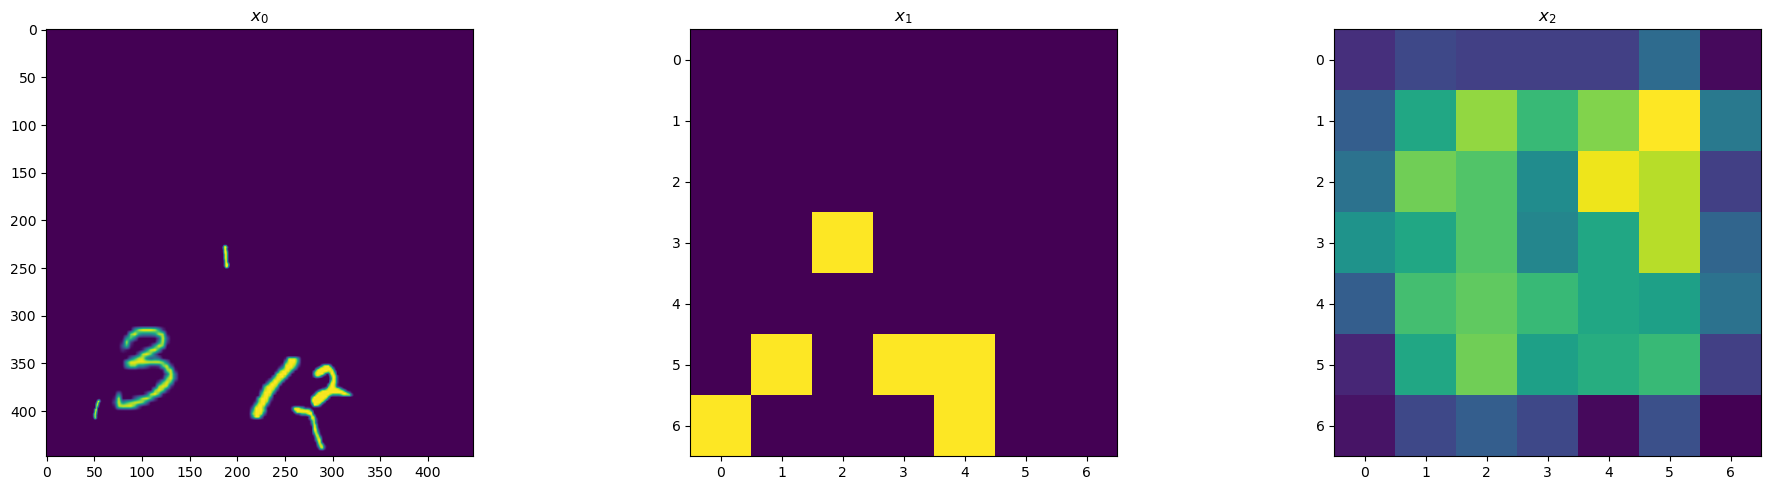

-------------------Training:1/300-------------------------------


 37%|███▋      | 23/63 [00:03<00:05,  6.79it/s]


KeyboardInterrupt: 

In [7]:
from model import YOLOv1, YOLOv1_resnet
import torchvision.transforms as T
from torch import nn
from torch import optim
import numpy as np
from utils import plot_images, clean_gpu
from tqdm import tqdm

clean_gpu()
torch.manual_seed(0)
#training loop
EPOCHS = 300
for epoch in range(EPOCHS):

    print(f'-------------------Training:{epoch}/{EPOCHS}-------------------------------')

    n_break = 0
    model.train()
    for idx, data in enumerate(tqdm(train_loader)):
    
        # zero the parameters
        optimizer.zero_grad()
        
        # forward
        img, target = data
        img = img.to(device)
        prediction = model(img)

        # loss evaluation
        loss = yolov1_loss_function(mse, target, prediction)

        #print(loss)
        loss.backward()
        optimizer.step()
        #print(loss)

        loss_history.append(loss.detach().item())

    print(f'Loss at {epoch}/{EPOCHS} is: {np.average(np.array(loss_history))}')

    print("-------------------Testing-------------------------------")
    model.eval()
    for idx, data in enumerate(train_loader):
        
        # forward
        img, target = data
        img = img.to(device)
        prediction = model(img)

        loss = yolov1_loss_function(mse, target, prediction)

        print(f"Loss during test:{loss.detach().item()}")

        img2show = img.detach()[0,...].cpu()
        target2show = target['one_obj'].squeeze().detach()[0,...].cpu()
        predict2show = prediction[...,0].squeeze().detach()[0,...].cpu()
        

        plot_images([img2show, target2show, predict2show], title='awd')

        if idx == n_break:
            break
        

In [ ]:
print("-------------------Testing-------------------------------")
n_break = 0
model.eval()
for idx, data in enumerate(train_loader):

    # get the inputs
    img, target = data
    img, target = img.to(device), target['one_obj'].to(device)

    # forward
    prediction = model(img)
    target_confidence_obj = target.squeeze()
    predict_confidence_obj = prediction.squeeze()


    # backward + optimize
    loss = mse(
        torch.flatten(target_confidence_obj, start_dim=1), 
        torch.flatten(predict_confidence_obj*target_confidence_obj, start_dim=1)
    ) 
    
    loss += 0.5*mse(
        torch.flatten(target_confidence_obj*(1 - target_confidence_obj), start_dim=1),
            torch.flatten(predict_confidence_obj*(1 - target_confidence_obj), start_dim=1)
    )

    print(f"Loss during test:{loss.detach().item()}")

    img2show = img.detach()[0,...].cpu()
    target2show = target_confidence_obj.detach()[0,...].cpu()
    predict2show = predict_confidence_obj.detach()[0,...].cpu()
    
    plot_images([img2show, target2show, predict2show], title='awd')

    if idx == n_break:
        break
    


NameError: name 'model' is not defined